In [ ]:
!pip install --quiet bbknn
!pip install --quiet scvelo
!pip install --quiet scanpy
!pip install --quiet anndata
!pip install --quiet python-igraph





In [ ]:
import scanpy as sc # Core scverse libraries
import anndata as ad # Core scverse libraries
import igraph as ig # Core scverse libraries
import bbknn # Batch effect correction (batch balanced k nearest neighbour)
import scvelo as scv # Velocity
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [ ]:
# Load normalised data
adata = sc.read_h5ad('/content/drive/MyDrive/Mammary gland Dataset/filtered_data_normalised.h5ad')

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 40639 × 2082
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'EnsemblId', 'Gene Name Full', 'Info', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'log1p', 'pca', 'scrublet'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [ ]:
adata.obs.head()

batch  n_genes  n_genes_by_counts  \
barcode                                                                     
AAACCTGAGACTAGGC-1-GSM4909253_N  GSM4909253_N     1359               1359   
AAACCTGAGGACAGAA-1-GSM4909253_N  GSM4909253_N      510                510   
AAACCTGCAAGAGGCT-1-GSM4909253_N  GSM4909253_N     2594               2595   
AAACCTGGTAGCTTGT-1-GSM4909253_N  GSM4909253_N      733                734   
AAACGGGAGAGGTAGA-1-GSM4909253_N  GSM4909253_N      455                455   

                                 log1p_n_genes_by_counts  total_counts  \
barcode                                                                  
AAACCTGAGACTAGGC-1-GSM4909253_N                 7.215240        3587.0   
AAACCTGAGGACAGAA-1-GSM4909253_N                 6.236370        1003.0   
AAACCTGCAAGAGGCT-1-GSM4909253_N                 7.861727       10366.0   
AAACCTGGTAGCTTGT-1-GSM4909253_N                 6.599870        1628.0   
AAACGGGAGAGGTAGA-1-GSM4909253_N                 6.122493        1230.0   

                                 log1p_total_counts  total_counts_mt  \
barcode                                                                
AAACCTGAGACTAGGC-1-GSM4909253_N            8.185350            287.0   
AAACCTGAGGACAGAA-1-GSM4909253_N            6.911747              4.0   
AAACCTGCAAGAGGCT-1-GSM4909253_N            9.246383            408.0   
AAACCTGGTAGCTTGT-1-GSM4909253_N            7.395721             43.0   
AAACGGGAGAGGTAGA-1-GSM4909253_N            7.115582             26.0   

                                 log1p_total_counts_mt  pct_counts_mt  \
barcode                                                                 
AAACCTGAGACTAGGC-1-GSM4909253_N               5.662961       8.001115   
AAACCTGAGGACAGAA-1-GSM4909253_N               1.609438       0.398804   
AAACCTGCAAGAGGCT-1-GSM4909253_N               6.013715       3.935944   
AAACCTGGTAGCTTGT-1-GSM4909253_N               3.784190       2.641278   
AAACGGGAGAGGTAGA-1-GSM4909253_N               3.295837       2.113821   

                                 total_counts_ribo  log1p_total_counts_ribo  \
barcode                                                                       
AAACCTGAGACTAGGC-1-GSM4909253_N             1220.0                 7.107426   
AAACCTGAGGACAGAA-1-GSM4909253_N              415.0                 6.030685   
AAACCTGCAAGAGGCT-1-GSM4909253_N             2854.0                 7.956827   
AAACCTGGTAGCTTGT-1-GSM4909253_N              481.0                 6.177944   
AAACGGGAGAGGTAGA-1-GSM4909253_N              382.0                 5.948035   

                                 pct_counts_ribo  total_counts_hb  \
barcode                                                             
AAACCTGAGACTAGGC-1-GSM4909253_N        34.011711              0.0   
AAACCTGAGGACAGAA-1-GSM4909253_N        41.375874              0.0   
AAACCTGCAAGAGGCT-1-GSM4909253_N        27.532318              0.0   
AAACCTGGTAGCTTGT-1-GSM4909253_N        29.545454              0.0   
AAACGGGAGAGGTAGA-1-GSM4909253_N        31.056911              0.0   

                                 log1p_total_counts_hb  pct_counts_hb  \
barcode                                                                 
AAACCTGAGACTAGGC-1-GSM4909253_N                    0.0            0.0   
AAACCTGAGGACAGAA-1-GSM4909253_N                    0.0            0.0   
AAACCTGCAAGAGGCT-1-GSM4909253_N                    0.0            0.0   
AAACCTGGTAGCTTGT-1-GSM4909253_N                    0.0            0.0   
AAACGGGAGAGGTAGA-1-GSM4909253_N                    0.0            0.0   

                                 doublet_score  predicted_doublet  
barcode                                                            
AAACCTGAGACTAGGC-1-GSM4909253_N       0.030505              False  
AAACCTGAGGACAGAA-1-GSM4909253_N       0.045359              False  
AAACCTGCAAGAGGCT-1-GSM4909253_N       0.091116              False  
AAACCTGGTAGCTTGT-1-GSM4909253_N       0.015625              False  
AAACGG

In [ ]:
adata.var.head()

EnsemblId Gene Name Full             Info  n_cells     mt  \
Gene Name                                                                    
ISG15      ENSG00000187608          ISG15  Gene Expression     5147  False   
TNFRSF4    ENSG00000186827        TNFRSF4  Gene Expression     1330  False   
MXRA8      ENSG00000162576          MXRA8  Gene Expression     1063  False   
AL645728   ENSG00000215014     AL645728.1  Gene Expression      824  False   
SKI        ENSG00000157933            SKI  Gene Expression     3937  False   

            ribo     hb  n_cells_by_counts  mean_counts  log1p_mean_counts  \
Gene Name                                                                    
ISG15      False  False               5597     0.222313           0.200745   
TNFRSF4    False  False               1409     0.082340           0.079125   
MXRA8      False  False               1198     0.033127           0.032590   
AL645728   False  False                983     0.023177           0.022913   
SKI        False  False               4494     0.126413           0.119038   

           pct_dropout_by_counts  total_counts  log1p_total_counts  \
Gene Name                                                            
ISG15                  87.598050       10033.0            9.213735   
TNFRSF4                96.877908        3716.0            8.220673   
MXRA8                  97.345446        1495.0            7.310550   
AL645728               97.821848        1046.0            6.953684   
SKI                    90.042101        5705.0            8.649274   

           highly_variable     means  dispersions  dispersions_norm  \
Gene Name                                                             
ISG15                 True  0.283840     2.207596          1.883032   
TNFRSF4               True  0.126641     2.178553          1.829798   
MXRA8                 True  0.062286     1.545667          0.669747   
AL645728              True  0.033687     1.547148          0.672461   
SKI                   True  0.144890     1.495212          0.577265   

                   mean       std  
Gene Name                          
ISG15      2.797481e-18  0.396923  
TNFRSF4    1.398741e-18  0.271572  
MXRA8      7.693073e-18  0.191371  
AL645728  -2.797481e-18  0.136308  
SKI       -6.993703e-18  0.279979

#Nearest Neighbour Graph Construction and Visualization

In [ ]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:08)


In [ ]:
#Batch effect correction
sc.external.pp.bbknn(adata, batch_key="batch")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)


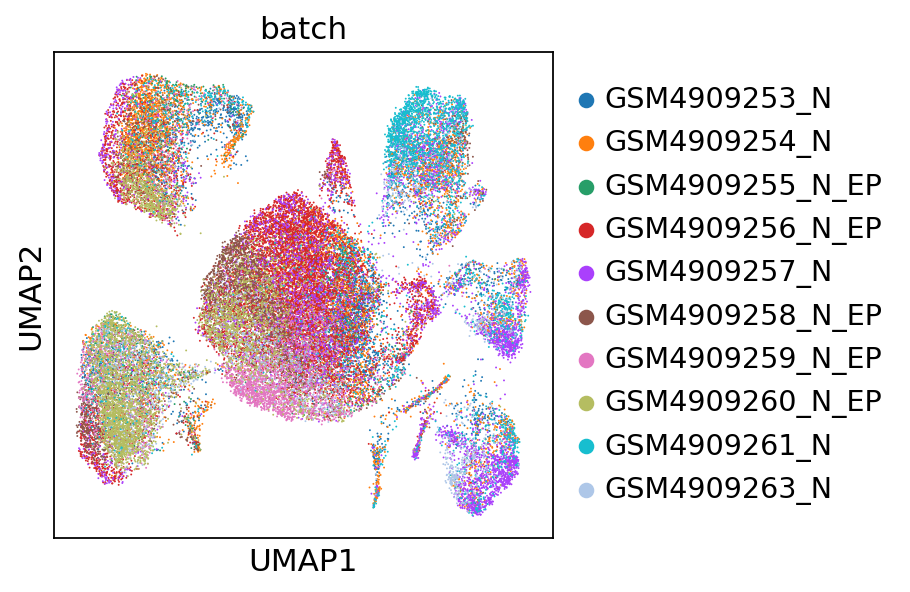

In [ ]:
sc.pl.umap(
    adata,
    color="batch",
    frameon=True,
)

#Clustering

In [ ]:
#Checking for clusters with different resolutions
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res1", resolution=1)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0_02', the cluster labels (adata.obs, categorical) (0:00:08)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:06)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:08)


#Embedding the neighborhood graph

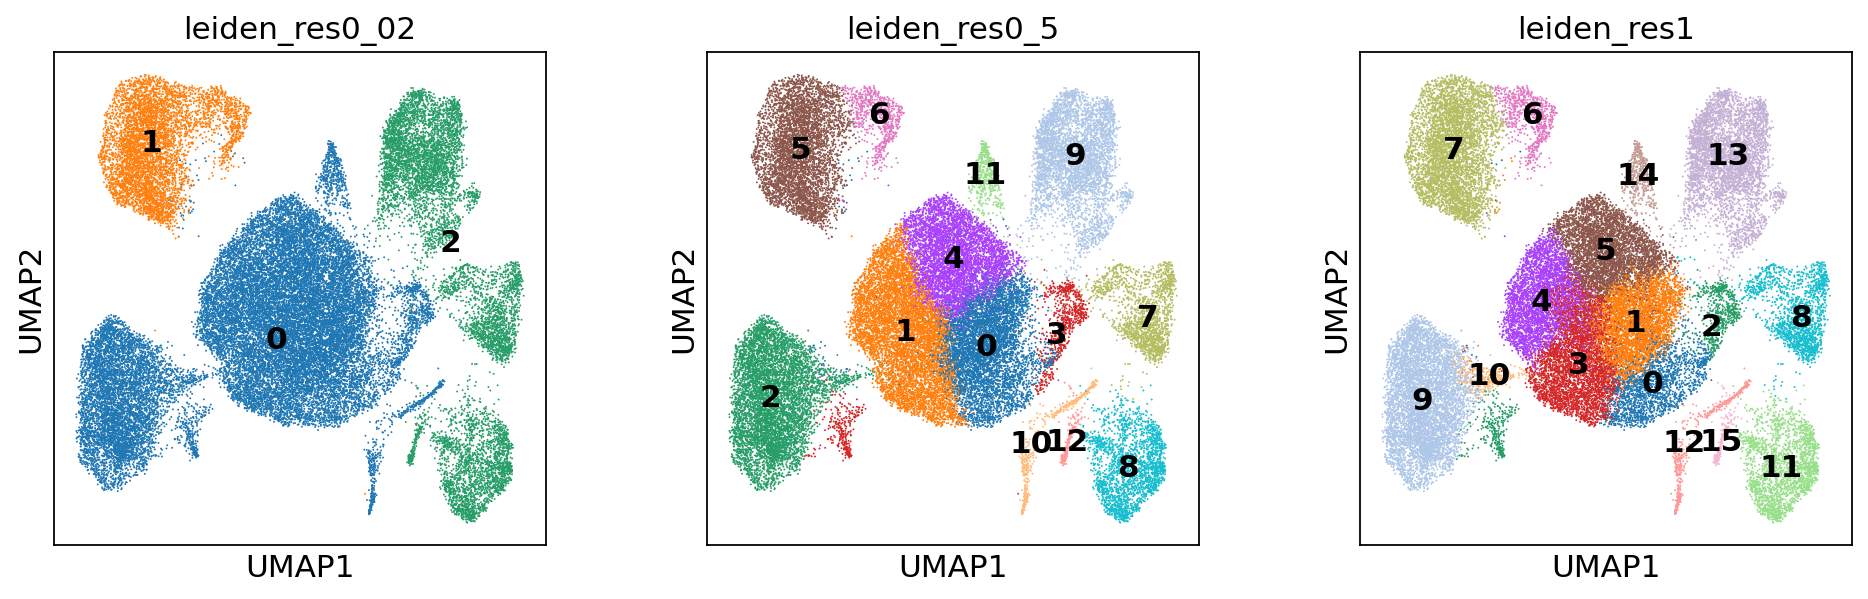

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
    frameon=True,
    #save=".pdf"
)

In [ ]:
# Calculate the hierarchy clustering
sc.tl.dendrogram(adata, groupby='leiden_res0_5')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res0_5']`


In [ ]:
# Assign the clustering result to 'hierarchy' in adata.obs
adata.obs['hierarchical'] = adata.obs['leiden_res0_5'].astype('category')

In [ ]:
adata

AnnData object with n_obs × n_vars = 40639 × 2082
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'leiden_res0_02', 'leiden_res0_5', 'leiden_res1', 'hierarchical'
    var: 'EnsemblId', 'Gene Name Full', 'Info', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'log1p', 'pca', 'scrublet', 'neighbors', 'umap', 'leiden_res0_02', 'leiden_res0_5', 'leiden_res1', 'leiden_res0_02_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'dendrogram_leiden_res0_5'
    obsm: 'X_pca', 'X_umap'
    varm: 

#Finding Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:14)


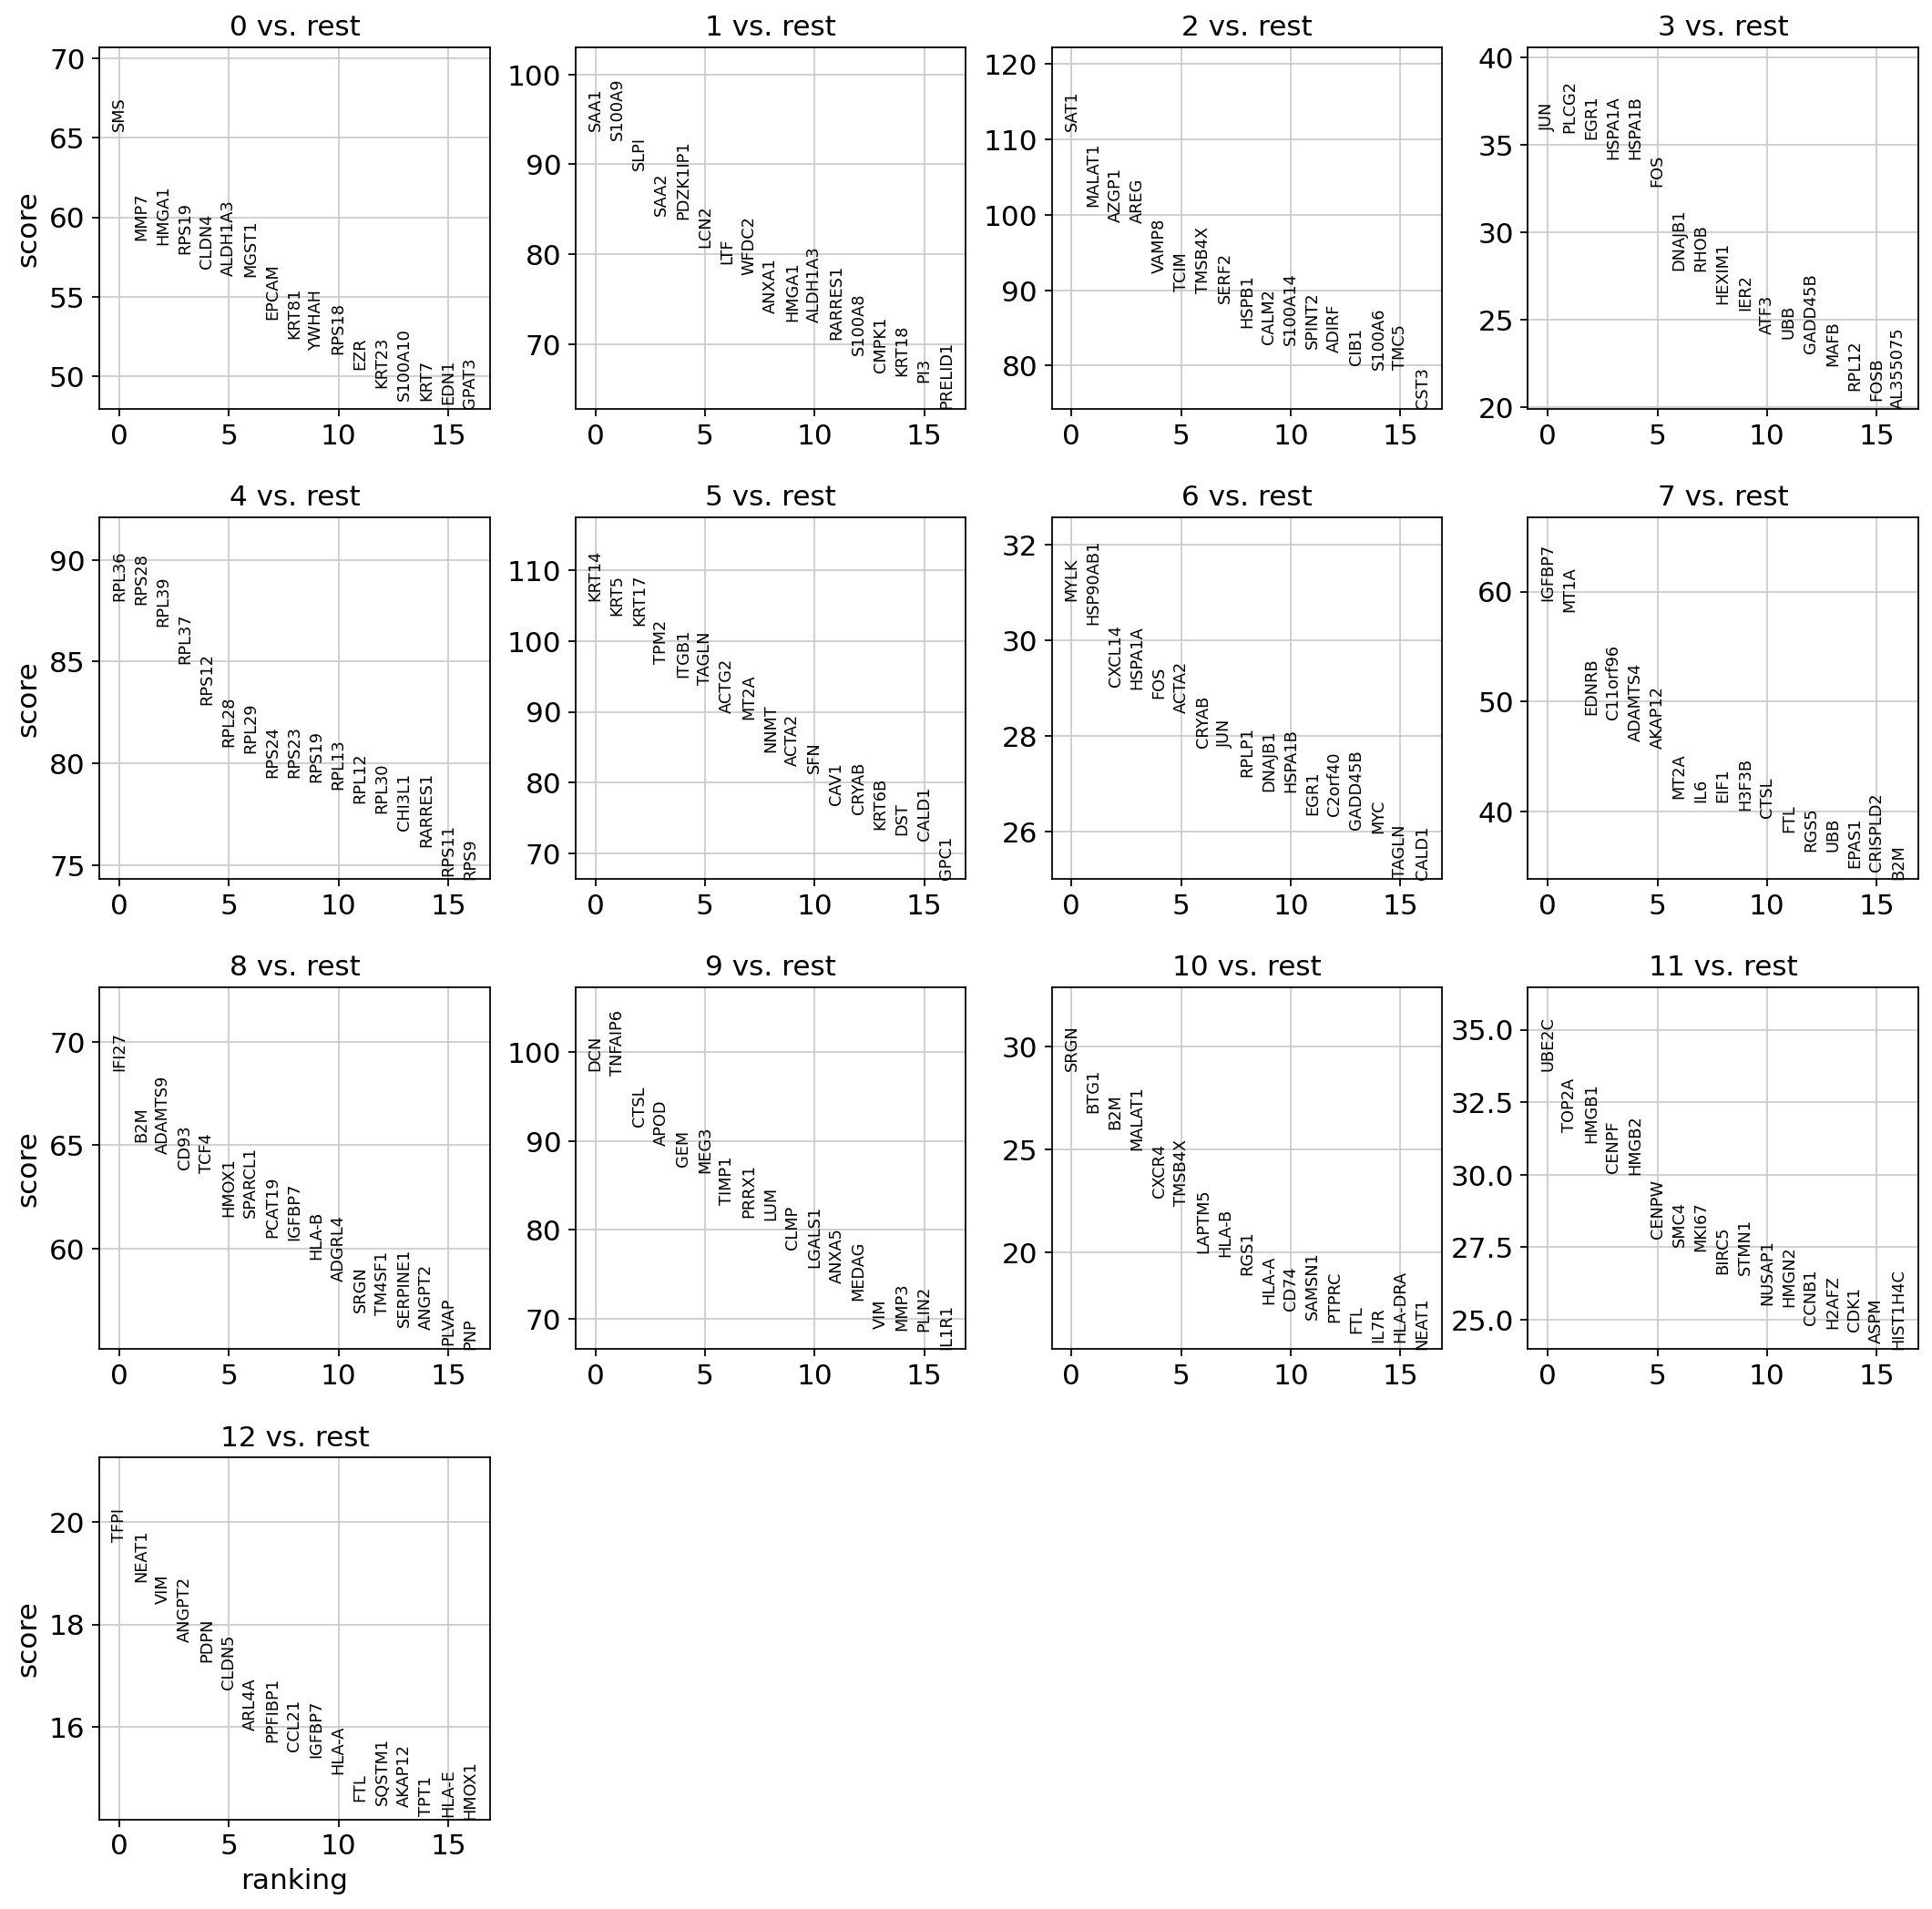

In [ ]:
# Perform rank genes analysis
sc.tl.rank_genes_groups(adata, 'hierarchical', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=17, sharey=False)

In [ ]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(15)

0         1        2        3        4      5         6         7  \
0       SMS      SAA1     SAT1      JUN    RPL36  KRT14      MYLK    IGFBP7   
1      MMP7    S100A9   MALAT1    PLCG2    RPS28   KRT5  HSP90AB1      MT1A   
2     HMGA1      SLPI    AZGP1     EGR1    RPL39  KRT17    CXCL14     EDNRB   
3     RPS19      SAA2     AREG   HSPA1A    RPL37   TPM2    HSPA1A  C11orf96   
4     CLDN4  PDZK1IP1    VAMP8   HSPA1B    RPS12  ITGB1       FOS   ADAMTS4   
5   ALDH1A3      LCN2     TCIM      FOS    RPL28  TAGLN     ACTA2    AKAP12   
6     MGST1       LTF   TMSB4X   DNAJB1    RPL29  ACTG2     CRYAB      MT2A   
7     EPCAM     WFDC2    SERF2     RHOB    RPS24   MT2A       JUN       IL6   
8     KRT81     ANXA1    HSPB1   HEXIM1    RPS23   NNMT     RPLP1      EIF1   
9     YWHAH     HMGA1    CALM2     IER2    RPS19  ACTA2    DNAJB1     H3F3B   
10    RPS18   ALDH1A3  S100A14     ATF3    RPL13    SFN    HSPA1B      CTSL   
11      EZR   RARRES1   SPINT2      UBB    RPL12   CAV1      EGR1       FTL   
12    KRT23    S100A8    ADIRF  GADD45B    RPL30  CRYAB   C2orf40      RGS5   
13  S100A10     CMPK1     CIB1     MAFB   CHI3L1  KRT6B   GADD45B       UBB   
14     KRT7     KRT18   S100A6    RPL12  RARRES1    DST       MYC     EPAS1   

           8        9      10      11       12  
0      IFI27      DCN    SRGN   UBE2C     TFPI  
1        B2M  TNFAIP6    BTG1   TOP2A    NEAT1  
2    ADAMTS9     CTSL     B2M   HMGB1      VIM  
3       CD93     APOD  MALAT1   CENPF   ANGPT2  
4       TCF4      GEM   CXCR4   HMGB2     PDPN  
5      HMOX1     MEG3  TMSB4X   CENPW    CLDN5  
6    SPARCL1    TIMP1  LAPTM5    SMC4    ARL4A  
7     PCAT19    PRRX1   HLA-B   MKI67  PPFIBP1  
8     IGFBP7      LUM    RGS1   BIRC5    CCL21  
9      HLA-B     CLMP   HLA-A   STMN1   IGFBP7  
10    ADGRL4   LGALS1    CD74  NUSAP1    HLA-A  
11      SRGN    ANXA5  SAMSN1   HMGN2      FTL  
12    TM4SF1    MEDAG   PTPRC   CCNB1   SQSTM1  
13  SERPINE1      VIM     FTL   H2AFZ   AKAP12  
14    ANGPT2     MMP3    IL7R    CDK1     TPT1

In [ ]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj<0.05) & (markers.logfoldchanges.abs()> .5)]
markers.head()

group  names     scores  logfoldchanges  pvals  pvals_adj
0     0    SMS  65.441872        1.959030    0.0        0.0
1     0   MMP7  58.579323        2.373949    0.0        0.0
2     0  HMGA1  58.269890        1.648125    0.0        0.0
3     0  RPS19  57.713646        0.638635    0.0        0.0
4     0  CLDN4  56.815727        1.797692    0.0        0.0

In [ ]:
sc.get.rank_genes_groups_df(adata, group='1').head()

names     scores  logfoldchanges  pvals  pvals_adj
0      SAA1  93.732643        3.534175    0.0        0.0
1    S100A9  92.734436        4.133245    0.0        0.0
2      SLPI  89.394073        3.609141    0.0        0.0
3      SAA2  84.339989        3.199435    0.0        0.0
4  PDZK1IP1  83.862625        2.707472    0.0        0.0

In [ ]:
#list of marker genes
marker_genes = {
    "Basal cells": ['KRT17'],
    "Basal Epithalial Cells": ['MYLK','KRT14','KRT5'],
    #'Perivascular cells': ['TAGLN','ITGB1'],
    'Myofibroblast': ['VIM'],
    "Luminal Cells": ['KRT18','KRT8'],
    "Luminal Epithalial Cells": ['KRT81','KRT23', 'KRT15'],
    #"Luminal Progenitor Cells": ['KRT19','SLPI'],
    "Epithelial Cells":['EPCAM'],
    "Epithelial Progenitor Cells":['CD24'],
    "Stromal Cells": ['ACTA2'],
    "Pericyte": ['RGS5','TAGLN'],
    #"Cancer Stem Cells": ['ALDH1A3', 'CD24','MYC','PROCR','CXCR4'],
    #"Cancer Cell": ['KRT7','KRT19','TRPS1','GOLM1','ENG','MKI67'],
    #"Adipocytes": ['APOD','CFD','DLK1'],
    "CD8+ T Cells": ['HLA-E','HLA-DRA'],
    "T follicular helper": ['CD200'],
    #"T helper 1": ['ZEB2'],
    "Proliferating T Cell": ['MKI67'],
    "Exhausted CD8+ T Cells": ['HLA-DRB1','ALOX5AP','IFI27','HLA-DRA'],
    #"Antigen Presentation Cancer-Associated Fibrblast": ['CD74', 'CAV1'],
    "Fibroblast": ["DCN"],
    #"Dendritic Cells": ['HLA-DPA1','HLA-DPB1','HLA-DQB1','HLA-DRA'],
    "CD4+ T Cells": ["IL7R"],
    #"Macrophage": ['HLA-DPA1','LAPTM5','CD74','PTPRC'],
    #"Mesenchymal Cells": ['ZEB2', 'SPARC','MMP2'],
    #"T Cells": ['LAPTM5','PTPRC'],
    "Monocytes": ['S100A8','S100A9'],
    "Myeloid Dendrtic Cells": ['CCR7'],
    #"cancer-associated Fibroblast": ['PDPN','ACTA2','CAV1'],
    "Plasma Cells": ['LAPTM5','PTPRC'],
    "Mammary Stem Cells": ['CXCR4','KRT5','ITGB1','ALDH1A3', 'CD24'],


}

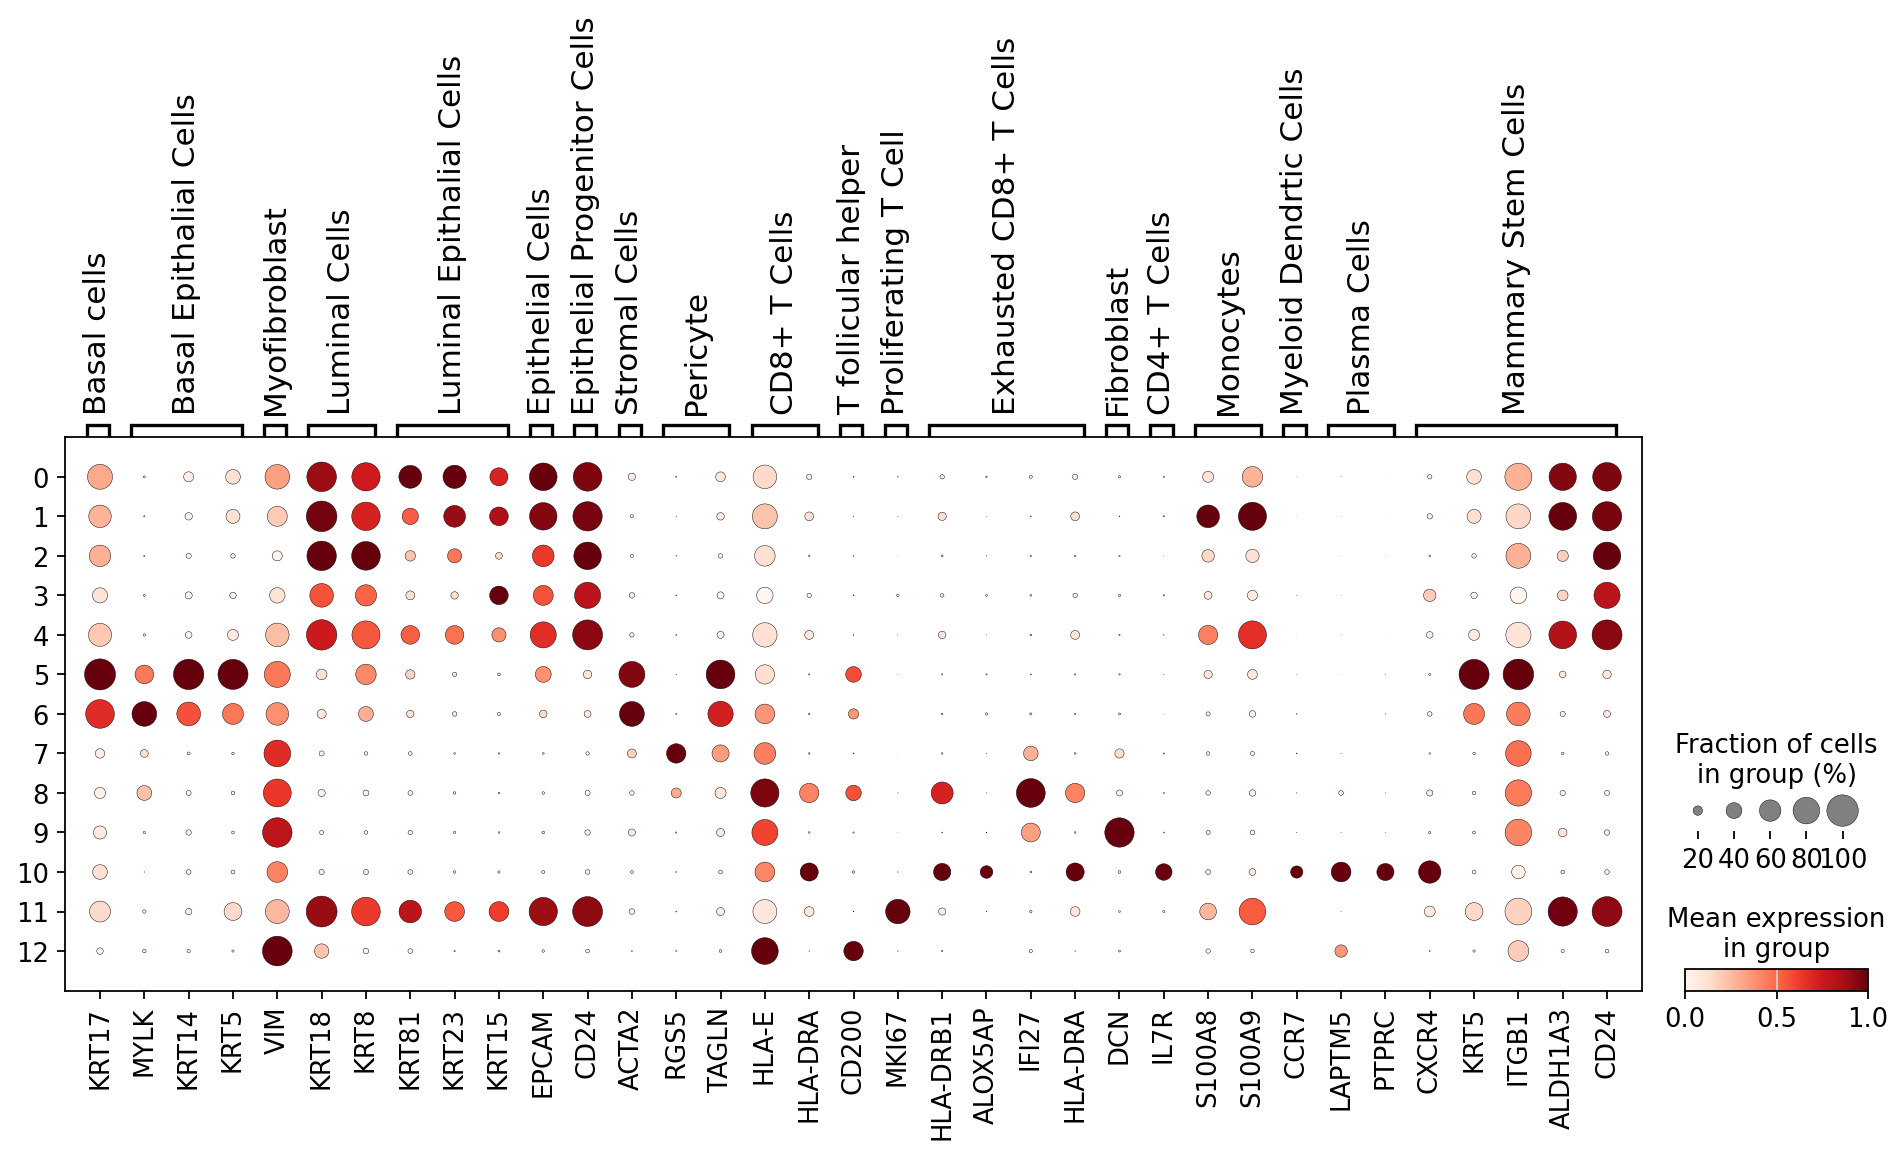

In [ ]:
sc.pl.dotplot(adata, marker_genes, standard_scale="var", groupby='leiden_res0_5')

In [ ]:
# Calculate the hierarchy clustering
sc.tl.dendrogram(adata, groupby='leiden_res0_5')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res0_5']`


In [ ]:
# Assign the clustering result to 'hierarchy' in adata.obs
adata.obs['hierarchical'] = adata.obs['leiden_res0_5'].astype('category')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_hierarchical']`


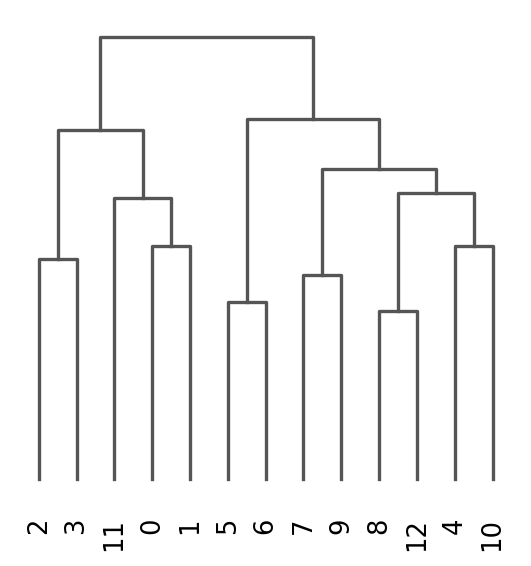

<Axes: >

In [ ]:
sc.pl.dendrogram(adata, groupby= 'hierarchical')

categories: 0, 1, 2, etc.
var_group_labels: Basal cells, Basal Epithalial Cells, Myofibroblast, etc.


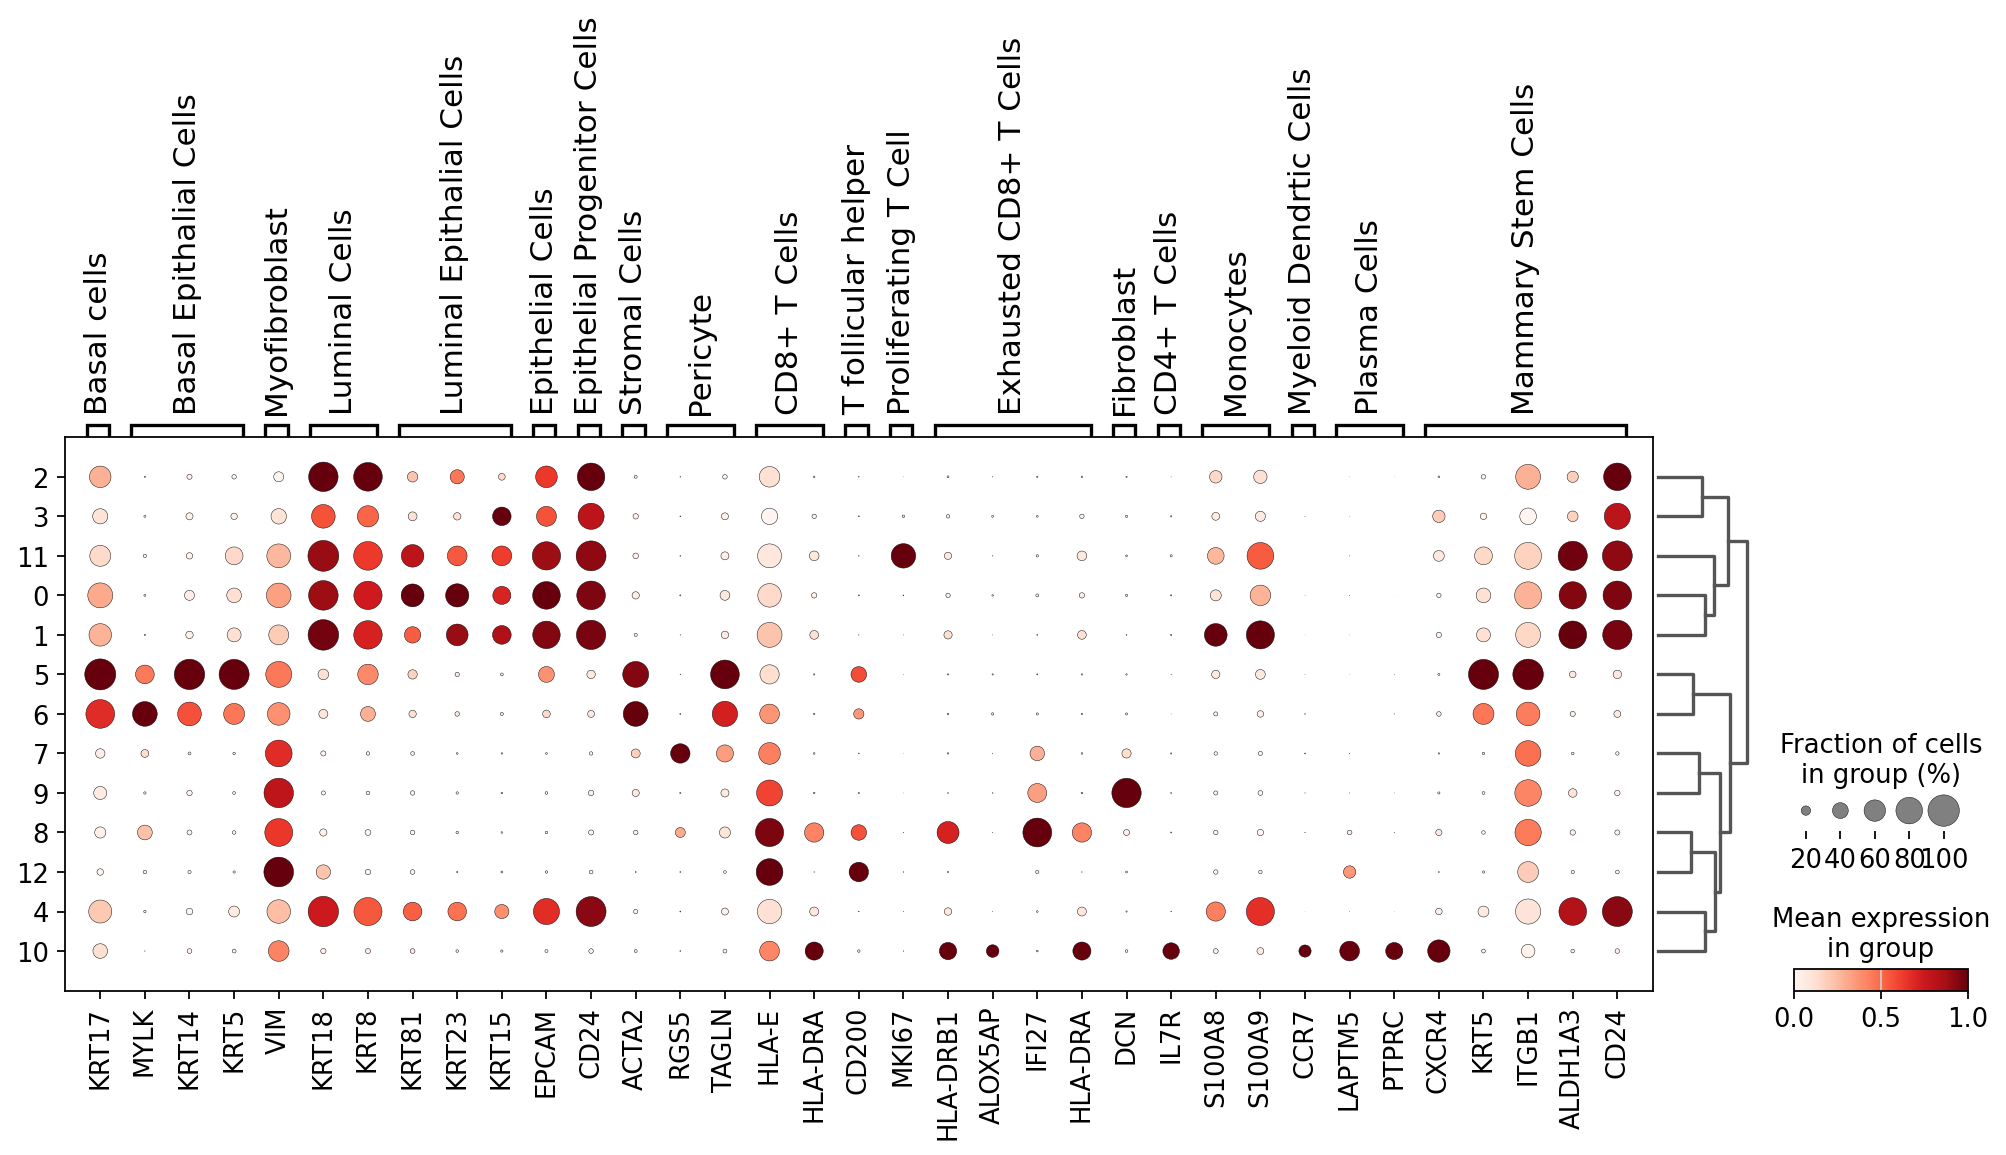

In [ ]:
sc.pl.dotplot(adata, marker_genes, standard_scale="var", groupby='hierarchical', dendrogram=True)

In [ ]:
#mark the cell types
Cell_Types = {
    "0": "Epithalial Cell",
    "1": "Monocytes",
    "2": "Luminal Cell",
    "3": "Luminal Epithelial Cell",
    "4": "Epithelial Progenitor Cell",
    "5": "Basal Cell",
    "6": "Stromal/Basal Epithelial Cells",
    "7": "Pericytes",
    "8": "Exhausted CD8+ Tcell",
    "9": "Fibroblast",
    "10": "Mammary Stem Cell",
    "11": "Proliferative T cell",
    "12": "Myofibroblast",

}
adata.obs["Cell_Types"] = adata.obs["hierarchical"].map(Cell_Types)

In [ ]:
sc.tl.dendrogram(
    adata, groupby = "Cell_Types",  #save=".pdf"
)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cell_Types']`


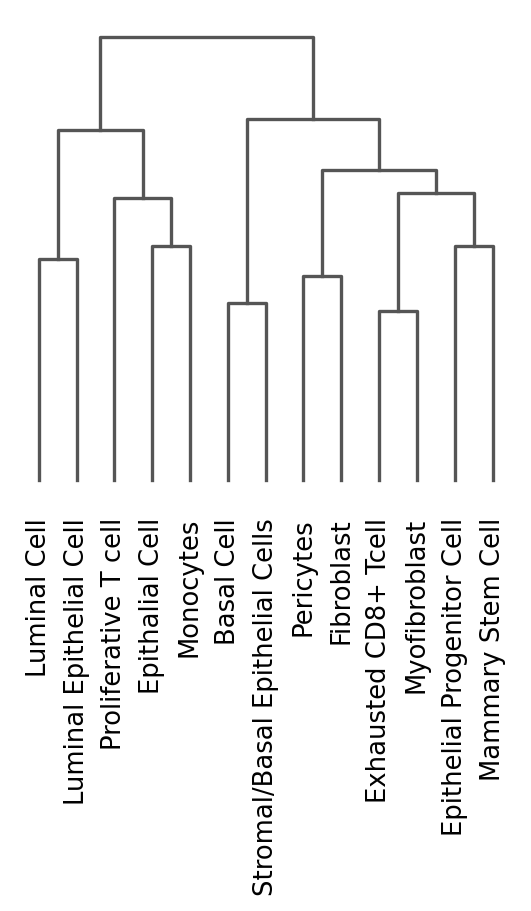

<Axes: >

In [ ]:
sc.pl.dendrogram(
    adata, groupby = "Cell_Types",  #save=".pdf"
)

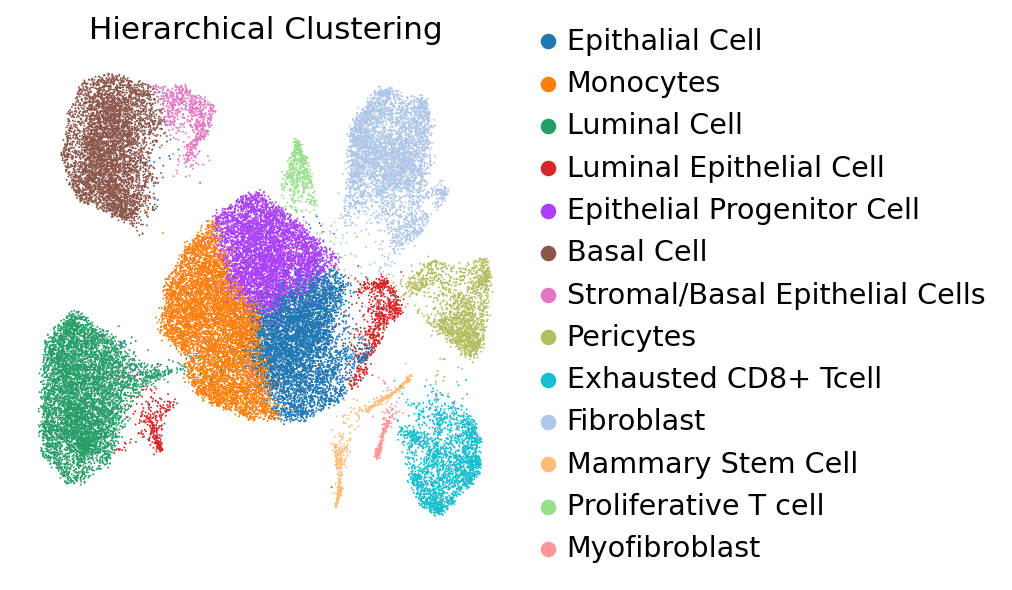

In [ ]:
sc.pl.umap(
    adata, color = "Cell_Types",  title="Hierarchical Clustering", frameon=False, #save=".pdf"
)

categories: Epithalial Cell, Monocytes, Luminal Cell, etc.
var_group_labels: Basal cells, Basal Epithalial Cells, Myofibroblast, etc.


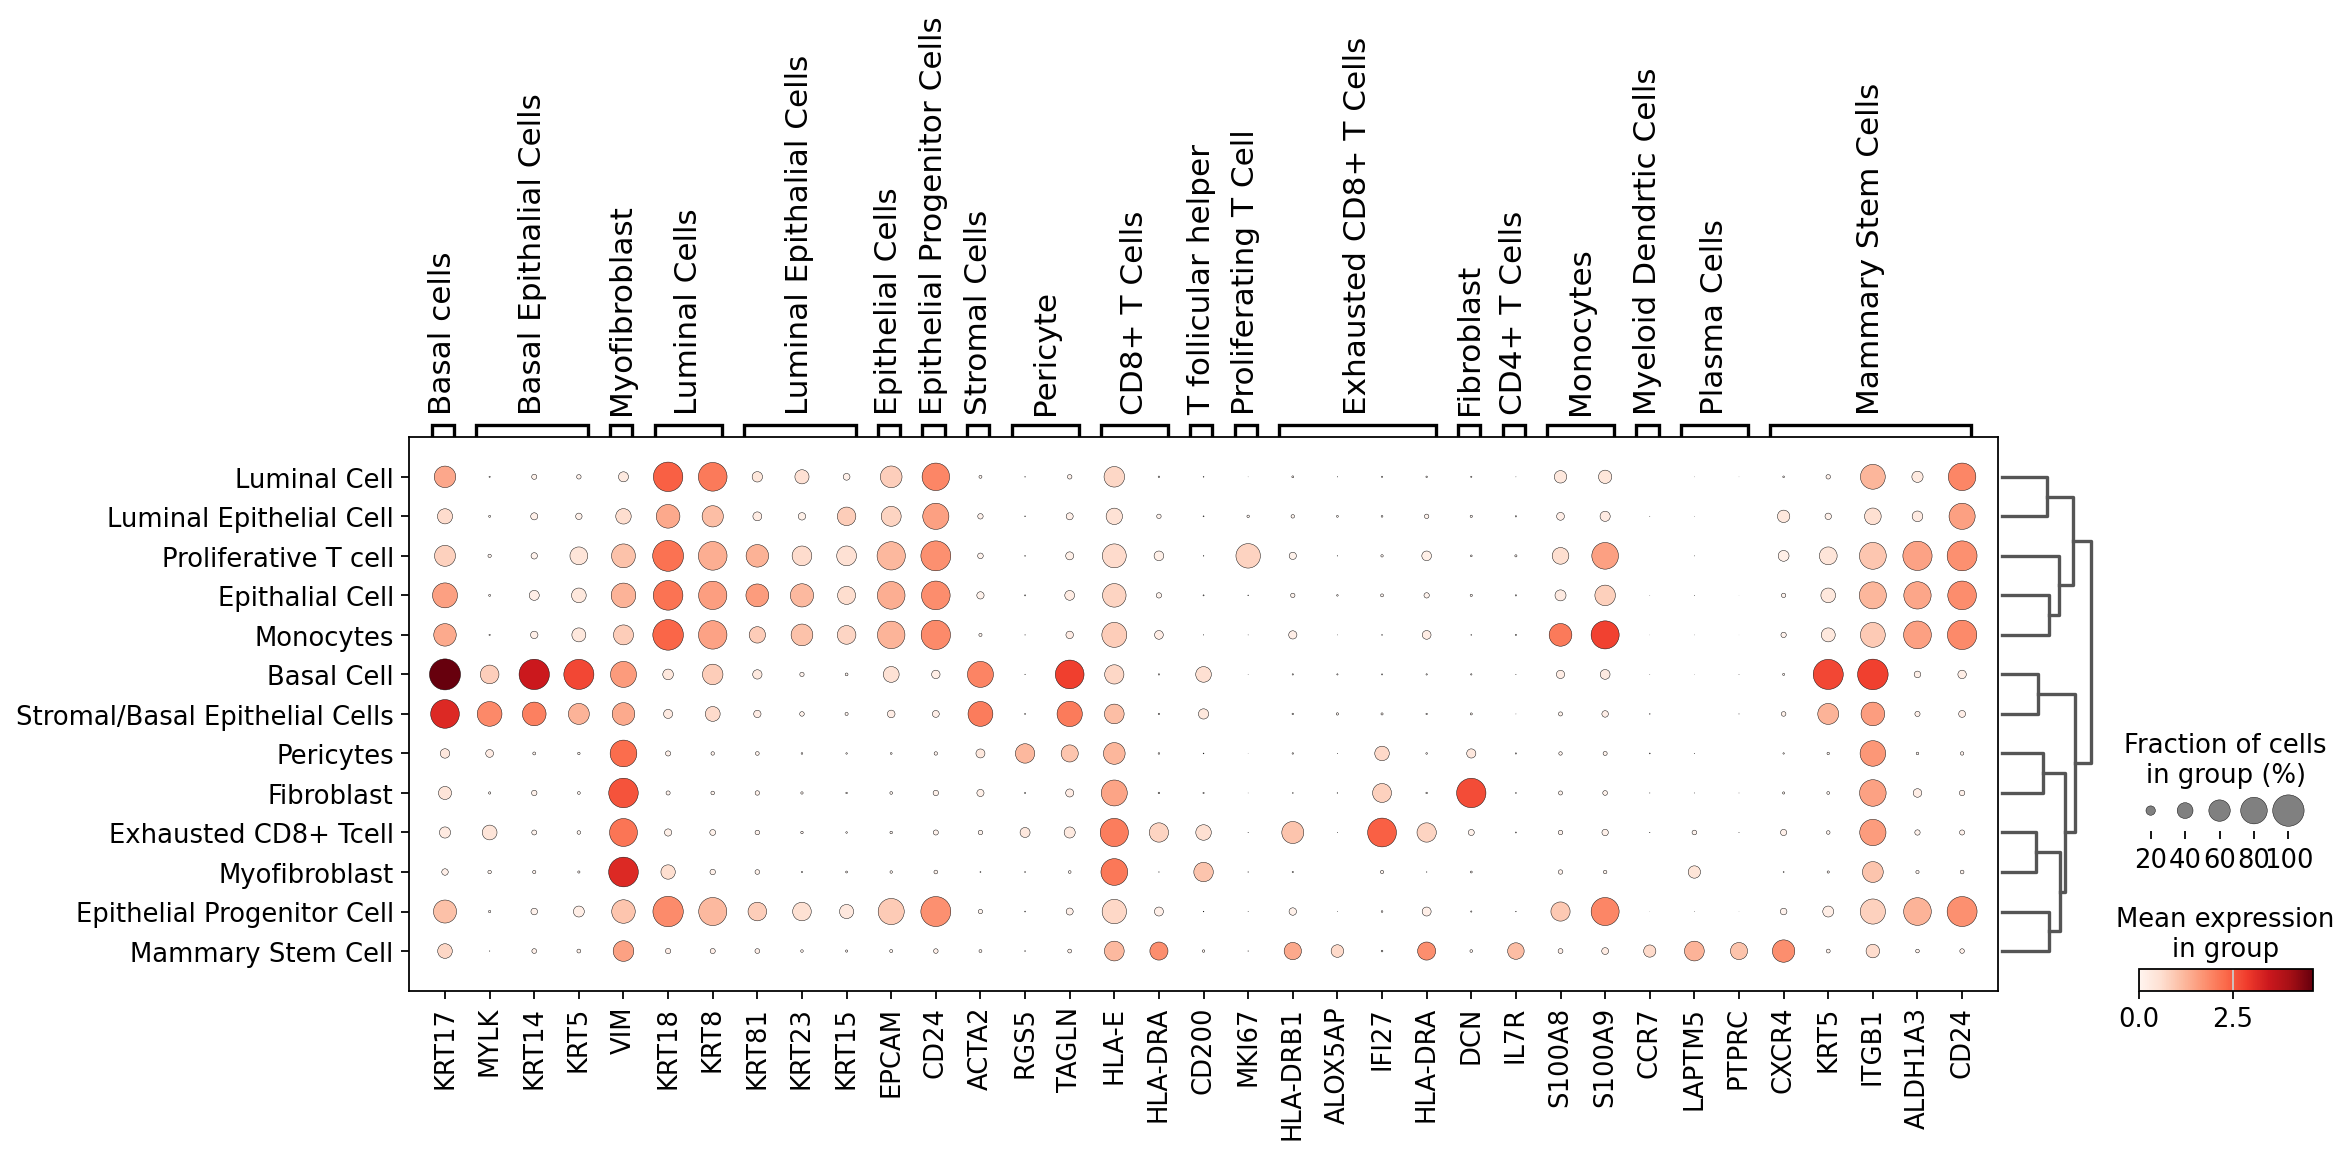

In [ ]:
# Label Cell Types
sc.pl.dotplot(adata, marker_genes, groupby="Cell_Types",dendrogram=True);

In [ ]:
sil_score_h = silhouette_score(adata.obsm['X_umap'], adata.obs['hierarchical'].astype(int))
print(f'Silhouette Score for Hierarchical Clustering: {sil_score_h:.4f}')

Silhouette Score for Hierarchical Clustering: 0.3961


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])


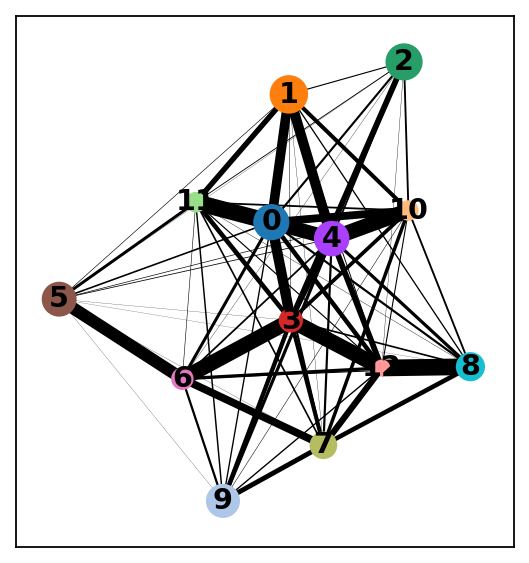

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:44)


In [ ]:
# Trajectory Inference
sc.tl.paga(adata, groups="leiden_res0_5")
sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')